In [3]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-03-07 21:46:47.935882: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 21:46:48.015758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 21:46:48.015841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 21:46:48.019281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 21:46:48.048394: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [4]:
dataset_dir = "Dataset/machine-learning-in-science-ii-2025/test_data/test_data"

ds = tf.data.Dataset.list_files(
    os.path.join(dataset_dir, "*"), shuffle=False
)
image_count = len(ds)

for f in ds.take(5):
    print(f.numpy())

# Extract image IDs
def extract_image_id(file_path):
    file_path = file_path.numpy().decode("utf-8")  # Convert from bytes to string
    filename = os.path.basename(file_path)  # Extract "1.png", "10.png", etc.
    image_id = filename.split(".")[0]  # Extract "1", "10", "100"
    return image_id

image_id_list = []

for path in ds:
    image_id_list.append(extract_image_id(path))

image_id_list = np.array(image_id_list)

2025-03-07 21:46:50.027279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-07 21:46:50.235439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-07 21:46:50.235494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-07 21:46:50.240144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-07 21:46:50.240202: I external/local_xla/xla/stream_executor

b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/10.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/100.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1000.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1001.png'


In [5]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [6]:
ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

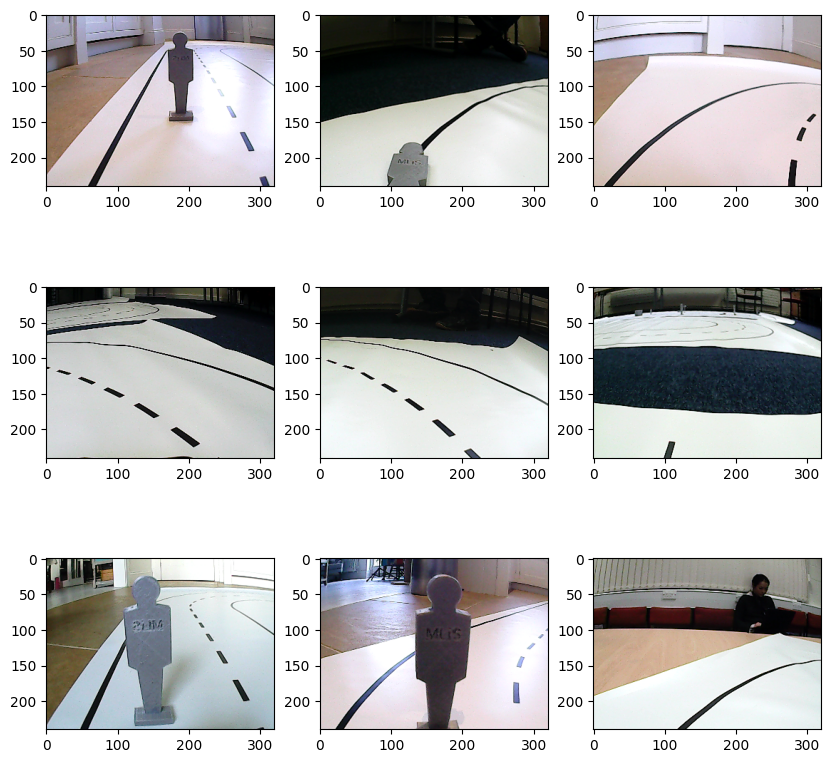

In [7]:
plt.figure(figsize=(10, 10))

i = 0

for image in ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    i += 1

In [8]:
def configure_for_performance(ds):
    ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = configure_for_performance(ds)

In [9]:
model = keras.models.load_model('/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/speed_model_20250307_2143_submission/speed_model_20250307_2143.keras'
                                , custom_objects={"WeightedBinaryCrossEntropy": WeightedBinaryCrossEntropy, "WeightedMeanSquaredError": WeightedMeanSquaredError})

In [10]:
pred = model.predict(ds)

2025-03-07 21:50:03.885967: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-07 21:50:04.097178: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-07 21:50:04.690962: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1020/1020 [==============================] - 15s 12ms/step


In [94]:
image_id_list

y_pred = []
for key in pred.keys():
    y_pred.append(pred[key][:, 0])

y_pred = np.array(y_pred)

y_pred = np.array(y_pred).T

y_pred = y_pred-0.5

y_pred[0]

def y_pred_map(y_pred):
    if abs(np.mean(y_pred)) > 0.4:
        return np.sign(np.mean(y_pred)) * 0.5 + 0.5
    else:
        return np.mean(y_pred)+0.5


y_pred_2 = []

for i in range(len(y_pred)):
    y_pred_2.append(y_pred_map(y_pred[i]))


y_pred_mean =(np.mean(y_pred, axis=1)>0).astype(int)

# speed_pred = output['speed_output'][:, 0]

# speed_pred = speed_pred > 0.5

# speed_pred = np.array(speed_pred).astype(int)

# print(speed_pred)
# print(image_id_list)

In [95]:
df = pd.DataFrame({
  'image_id': image_id_list.astype(int), 
  'speed': y_pred_2,
})
df

,image_id,speed
0,1,0.0
1,10,0.0
2,100,1.0
3,1000,1.0
4,1001,1.0
...,...,...
1015,995,0.0
1016,996,0.0
1017,997,1.0
1018,998,0.0


In [96]:
df = df.sort_values('image_id')
df

,image_id,speed
0,1,0.000000
132,2,1.000000
243,3,1.000000
354,4,1.000000
465,5,1.000000
...,...,...
20,1016,0.892455
21,1017,0.000000
22,1018,1.000000
23,1019,1.000000


38


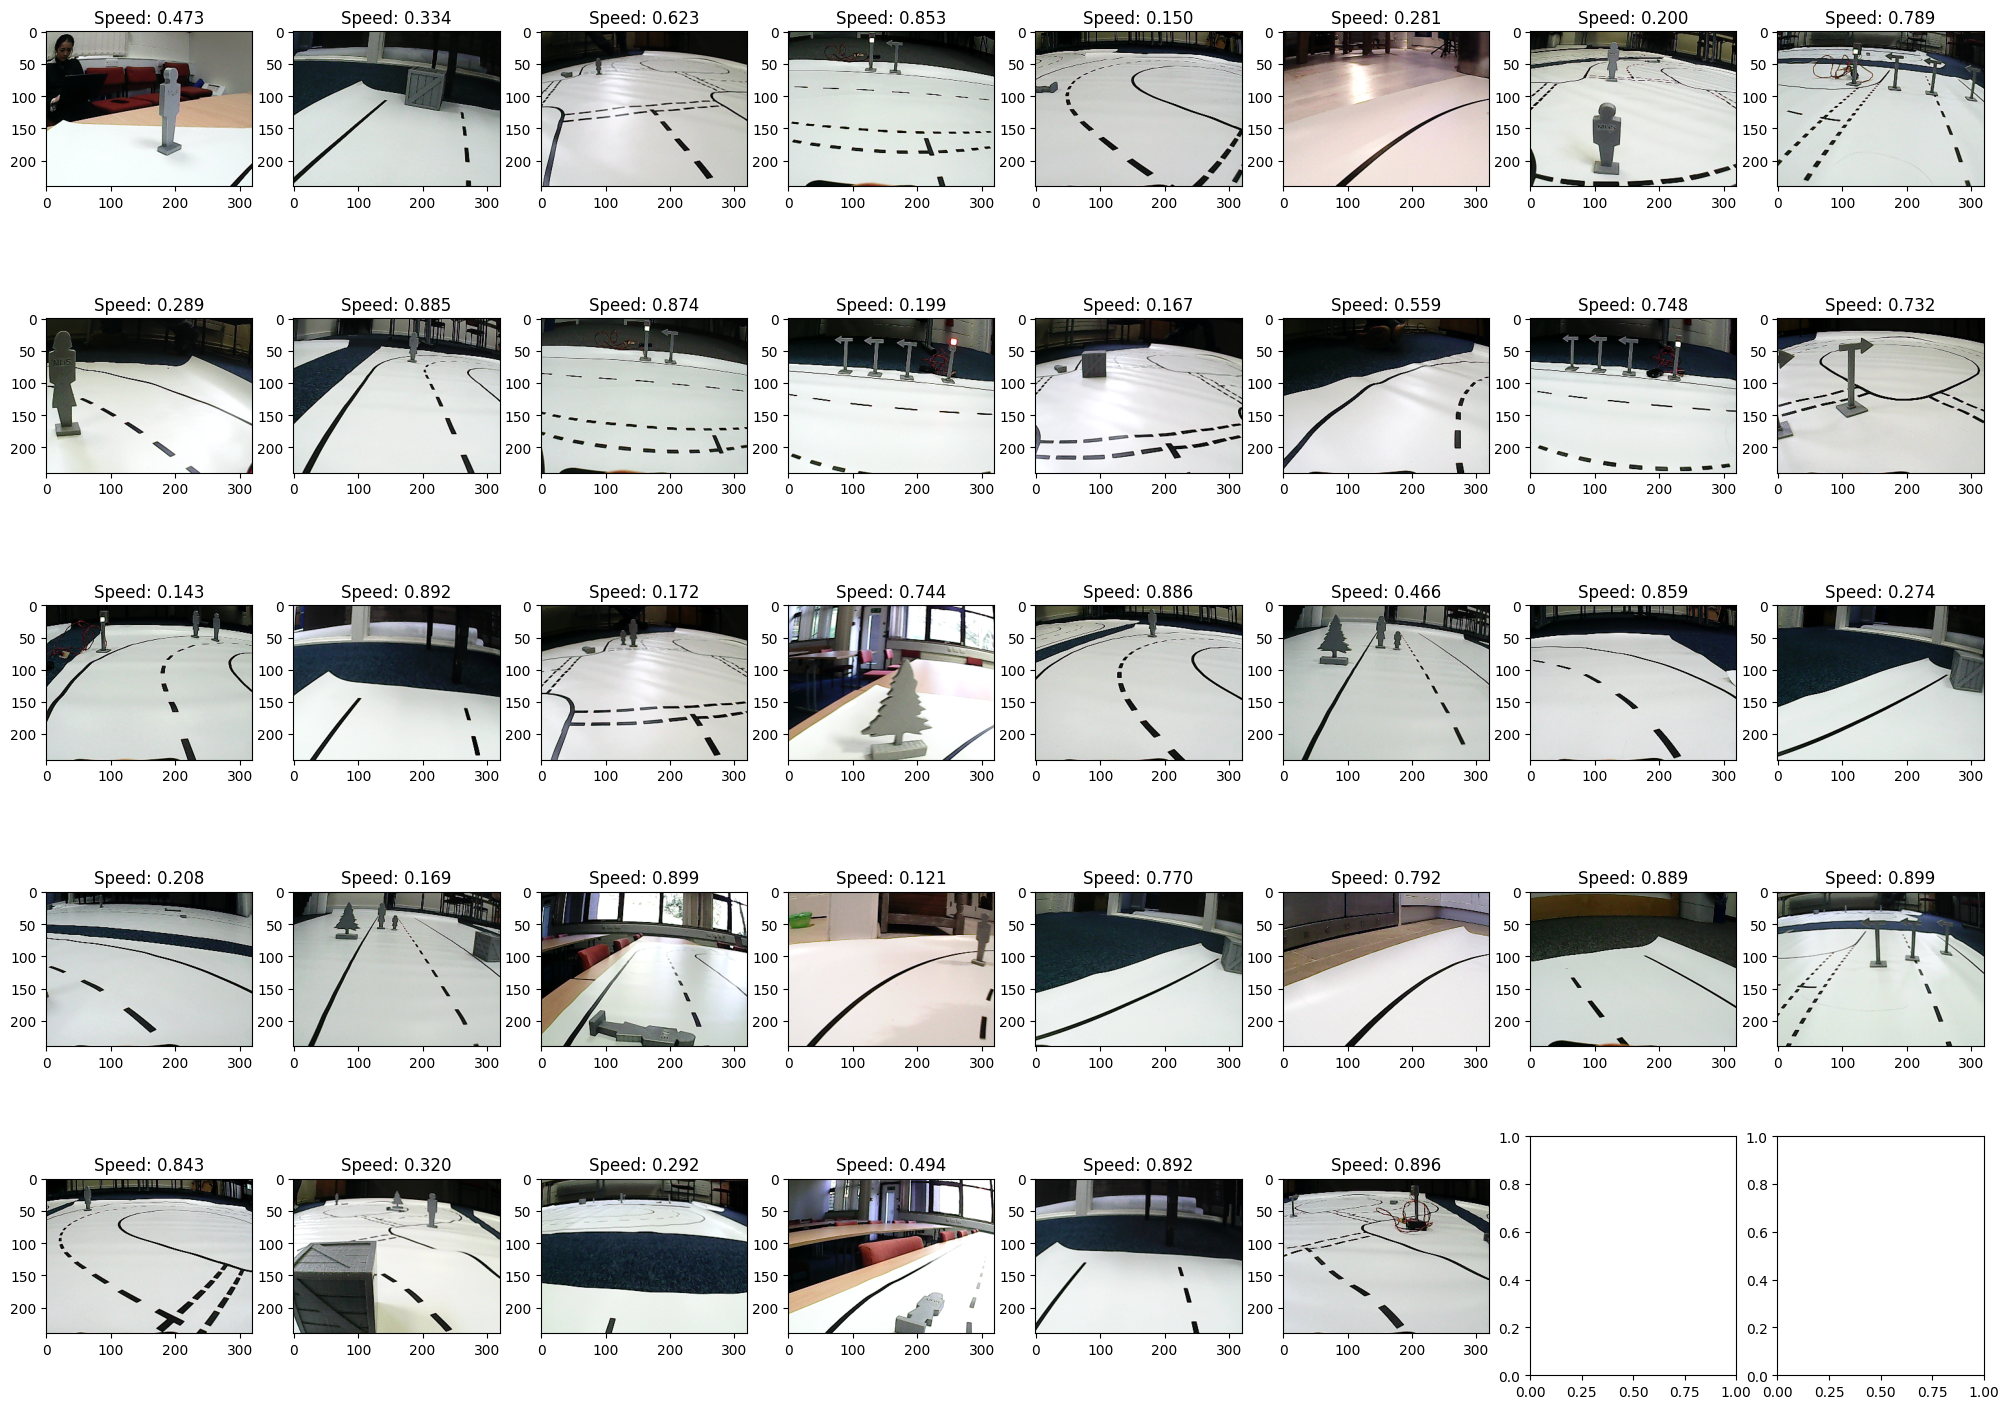

In [97]:
not_confident = df[(df['speed'] != 1) & (df['speed'] != 0)].reset_index(drop=True)
print(len(not_confident))

fig, ax = plt.subplots(5, 8, figsize=(25, 18))
ax = ax.ravel()

# print(not_confident)


for i in not_confident.index:
    image_id = (int(not_confident.loc[i]['image_id']))
    image_path = f"/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025/test_data/test_data/{image_id}.png"
    image = Image.open(image_path)
    ax[i].imshow(image)
    ax[i].set_title(f"Speed: {not_confident.loc[i]['speed']:.3f}")

In [99]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
df.to_csv(f'prediction_speed_{timestamp}.csv', index=False)

In [98]:
np.sum(np.array(y_pred_2)>0.5) / len(y_pred_2)

0.49901960784313726